<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/misc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook has the intention of being end-to-end, the below is installing the dependencies**

In [0]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other imports to handle files
import os
import pickle
import csv

# deep learning imports
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils, to_categorical
from keras.layers import LeakyReLU
from keras import regularizers

# to split our dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# to mount our drive
from google.colab import drive

In [34]:
# mount google drive into google colab
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where we will be working
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Build our model and fit on batches**

In [0]:
def initialise_model():

  # compile our model
  model = Sequential()
  
  model.add(Convolution3D(filters=32, kernel_size=3, padding='same', strides=1, input_shape=(128,128,128,1),
                          kernel_regularizer=regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005))) # padding on first one only?
  model.add(BatchNormalization(momentum=0.5)) 
  model.add(LeakyReLU(alpha=0.20)) # set to 0.01
  # could user he_norm kernel initializer?
  model.add(MaxPooling3D(pool_size=2, strides=2)) # pool_size=2
  
  model.add(Convolution3D(filters=64, kernel_size=3, padding='same', strides=2,
                          kernel_regularizer=regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005))) # padding on first one only?
  model.add(BatchNormalization(momentum=0.5)) 
  model.add(LeakyReLU(alpha=0.20)) # set to 0.01
  # could user he_norm kernel initializer?
  model.add(MaxPooling3D(pool_size=2, strides=2)) # pool_size=2
  
  model.add(Convolution3D(filters=128, kernel_size=3, padding='same', strides=2,
                          kernel_regularizer=regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005))) # padding on first one only?
  model.add(BatchNormalization(momentum=0.5)) 
  model.add(LeakyReLU(alpha=0.20)) # set to 0.01
  # could user he_norm kernel initializer?
  model.add(MaxPooling3D(pool_size=2, strides=2)) # pool_size=2
  
  model.add(Convolution3D(filters=256, kernel_size=3, padding='same', strides=2,
                          kernel_regularizer=regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005))) # padding on first one only?
  model.add(BatchNormalization(momentum=0.5)) 
  model.add(LeakyReLU(alpha=0.20)) # set to 0.01
  # could user he_norm kernel initializer?
  model.add(MaxPooling3D(pool_size=2, strides=2)) # pool_size=2
  
  model.add(Flatten())
   
  model.add(Dense(512, kernel_regularizer=regularizers.l2(0.005)))
  model.add(LeakyReLU(alpha=0.2)) # set to 0.01
  
  model.add(Dropout(0.20)) # add dropout to prevent overfitting
  
  model.add(Dense(64, kernel_regularizer=regularizers.l2(0.005)))
  model.add(LeakyReLU(alpha=0.2)) # set to 0.01
  
  model.add(Dropout(0.35)) # add dropout to prevent overfitting

  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',metrics = ['categorical_accuracy'])

  return model

In [42]:
model = initialise_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 128, 128, 128, 32) 896       
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 128, 32) 128       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 64, 64, 64, 32)    0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 32, 32, 32, 64)    55360     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32, 64)    256       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 32, 32, 32, 64)    0         
__________

In [0]:
# gets our y-values and converts to keras, one hot encoded outputs
def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

In [0]:
def get_metrics(hist):
  ''' Function to get our metrics from history and score as inputs'''

  # actually obtain our metrics
  val_loss = hist.history['val_loss'][0]
  val_acc = hist.history['categorical_accuracy'][0]
  train_loss = hist.history['loss'][0]
  train_acc = hist.history['categorical_accuracy'][0]

  # put everything into one array
  return [val_loss, val_acc, train_loss, train_acc]

In [0]:
def past_accuracies_fn(current_list, hist):
  '''Check if we have hit 100 accuracy for our entire dataset.
  If mean of 1, break, otherwise append to current list'''
  current_list = np.array(current_list)

  # only take 1 onward
  current_list = np.append(current_list, hist.history['categorical_accuracy'][0])
  current_list = current_list[1:]
  return current_list

In [46]:
os.getcwd()

'/content/gdrive/My Drive/msc_project'

In [47]:
ppath = 'all_mprage_grappa/processed_brains_aug_64x' # where to get the batches from
nname = '64x_04' # what to save as
# train on all, perhaps have different conditions for when we reach our last one
total_slices_train = os.listdir(ppath)[:3] # train on first 3, test on last one 
print (total_slices_train)

# Initialise Model!
model = initialise_model()

# set number of repeats and iterations
num_loopz = 1
num_iterations = 30

# stops when training accuracy is 1 across the board
past_accuracies = np.zeros(len(total_slices_train))
break_at_100 = 'YES' # basic boolean switch

for kk in range(num_loopz):
  
  file_name = (nname+str(kk)) ###filename, what we are changing
  for iteration in range(num_iterations):
    
    # check if we have training accuracy of 100, if so, exit training loop
    if ((np.mean(past_accuracies) == 1) and (break_at_100=='YES')):
      print ("Hit 100 on training accuracies")
      break

    print ("--------------------------------------------------------------------")
    print ("Current accuracy on training sets: %.2f " % np.mean(past_accuracies))
    print ("--------------------------------------------------------------------")
      
    # load and fit our model for our instances
    for tsf in total_slices_train:
      pkl_path = ppath+'/'+tsf

      # load pickle file
      with open(pkl_path, 'rb') as f:
        total_slices, total_slices_info = pickle.load(f)

      # convert to numpy array
      # total_slices = np.array(total_slices)
      # process y-values
      y_values = get_y_values(total_slices_info)
      
      # shuffle both of these
      # total_slices, y_values = unison_shuffled_copies(total_slices, y_values)

      # Run our model with validation of 5%
      hist = model.fit(x=total_slices, y=y_values, batch_size=1, epochs=1, verbose=1, shuffle=True,validation_split=0.05)
      # add to running totals
      past_accuracies = past_accuracies_fn(past_accuracies, hist) 
      # get metrics
      metrics = get_metrics(hist)

      # write to csv (want to append instead of overwrite)
      with open('all_mprage_grappa/z_tests/metrics/64x/metric'+file_name+'.csv', 'a') as csvFile:
          writer = csv.writer(csvFile)
          writer.writerow(metrics)
      csvFile.close()

      print ("Iteration: %d, batch %s" % (iteration, tsf[-1]))

  # save the model as reference, incase we need the brain heatmap
  model.save('all_mprage_grappa/z_tests/models/64x/model_'+file_name+'.h5', overwrite=True)  # saves as a hd5 file

['batch0', 'batch1', 'batch2']
--------------------------------------------------------------------
Current accuracy on training sets: 0.00 
--------------------------------------------------------------------
Train on 95 samples, validate on 5 samples
Epoch 1/1
95/95 [==============================] - 15s 156ms/step - loss: 4.5487 - categorical_accuracy: 0.6316 - val_loss: 4.6223 - val_categorical_accuracy: 0.4000
Iteration: 0, batch 0
Train on 95 samples, validate on 5 samples
Epoch 1/1
95/95 [==============================] - 11s 112ms/step - loss: 4.4998 - categorical_accuracy: 0.6000 - val_loss: 4.4910 - val_categorical_accuracy: 0.2000
Iteration: 0, batch 1
Train on 95 samples, validate on 5 samples
Epoch 1/1
95/95 [==============================] - 11s 111ms/step - loss: 4.6058 - categorical_accuracy: 0.4316 - val_loss: 4.4227 - val_categorical_accuracy: 0.2000
Iteration: 0, batch 2
--------------------------------------------------------------------
Current accuracy on training

**Test our model on dbatch 5, see how it does essentially**

In [35]:
# load our pickle batch of data
with open('all_mprage_grappa/processed_brains_aug_64x/batch4', 'rb') as f: # also 'total_slices_all.pkl' ## RENAMED 5 TO 7, TESTING IT
  total_slices, total_slices_info = pickle.load(f) # stored_batches/total_slices_batch5
  
# load our model
print ("Filename: %s" % file_name)
print ("Shape of slices: %s " % (np.shape(total_slices),))
model = load_model('all_mprage_grappa/z_tests/models/64x/model_'+file_name+'.h5')

# get corresponding y values
y_values = get_y_values(total_slices_info)

Filename: 64x_020
Shape of slices: (58, 128, 128, 128, 1) 


In [48]:
## Build function to load and build score on the fly then aggregate
divider = np.shape(total_slices)[0]/2

# Split into smaller chunks so our GPU can handle it
sub_arrays = np.array_split(total_slices, divider)
sub_y_values = np.array_split(y_values, divider)

score_sum = []
acc_sum = []
# run through model and test
for i in range(len(sub_arrays)):
  sub_array = sub_arrays[i]
  sub_y_value = sub_y_values[i]

  # got our scoring metric off the back of this too, all in one notebook
  if len(sub_y_value) == 1:
    sub_y_value = np.array([sub_y_value[0], sub_y_value[0]])
  score, acc = model.evaluate(sub_array, sub_y_value)
  score_sum.append(score)
  acc_sum.append(acc)
  
# get average values
mean_score = np.mean(score_sum)
mean_acc = np.mean(acc_sum)

print ("Test Score: %f, Test Accuracy: %f" % (mean_score, mean_acc))

2/2 [==============================] - 0s 37ms/step
Test Score: 2.506796, Test Accuracy: 0.980000


In [49]:
## Get the metrics and plot some graphs
metrics_df = pd.read_csv('all_mprage_grappa/z_tests/metrics/64x/metric'+file_name+'.csv', header=None)

# relabel headers
metrics_df.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc']

# aggregate so we have the averages of each batch (trains on 1 now and tests on 1)
batch_mean_df = metrics_df.groupby(np.arange(len(metrics_df))//3).mean()

# only want to take the last number of epochs we trained for
batch_mean_df = batch_mean_df.tail(30)

# get the final output (model at end)
batch_mean_df.iloc[-1,:]

val_loss      3.544156
val_acc       1.000000
train_loss    2.527818
train_acc     1.000000
Name: 10, dtype: float64

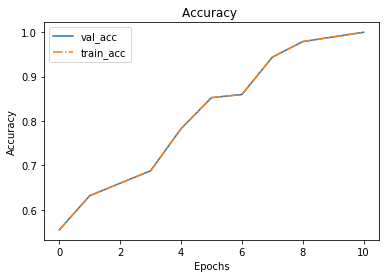

In [50]:
# plotting the accuracy
plt.plot(batch_mean_df.val_acc.values, label='val_acc', ls='-')
plt.plot(batch_mean_df.train_acc.values, label='train_acc', ls='-.')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy ')

plt.legend(loc='best')

plt.show()

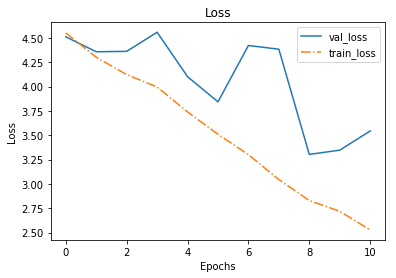

In [51]:
# plotting the loss
plt.plot(batch_mean_df.val_loss.values, label='val_loss', ls='-')
plt.plot(batch_mean_df.train_loss.values, label='train_loss', ls='-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.legend(loc='best')
plt.show()

**Visualise brainz**

In [15]:
slice_axials = total_slices[20]

# test slice

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # interactive plots
import matplotlib.pyplot as plt
%matplotlib inline

slice_ex = slice_axials[:,:,:,0]
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    plt.imshow(slice_ex[i])
    plt.show()
    return None

interact(g, i=widgets.IntSlider(min=0,max=(len(slice_ex)-1),step=1,value=65)); # plots our axial view, this is it
# img_slices, slice_info = process_slice(all_slices)

interactive(children=(IntSlider(value=65, description='i', max=127), Output()), _dom_classes=('widget-interact…

**Refactor our brainscans so that they are cubey**

In [0]:
# load our pickle batch of data
with open('stored_batches/total_slices_batch0.pkl', 'rb') as f: # also 'total_slices_all.pkl' ## RENAMED 5 TO 7, TESTING IT
  total_slices, total_slices_info = pickle.load(f) 

In [17]:
slice_axials = total_slices[20]

# test slice

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # interactive plots
import matplotlib.pyplot as plt
%matplotlib inline

slice_ex = slice_axials[25:180, 25:180, 10:170, 0] # what we will chunk out of each one of those

print (np.shape(slice_ex))
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    plt.imshow(slice_ex[i], cmap='gray')
    plt.show()
    return None

interact(g, i=widgets.IntSlider(min=0,max=(len(slice_ex)-1),step=1,value=65)); # plots our axial view, this is it
# img_slices, slice_info = process_slice(all_slices)

(155, 155, 150)


interactive(children=(IntSlider(value=65, description='i', max=154), Output()), _dom_classes=('widget-interact…